In [1]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice, AnalogDevice
from pulser.waveforms import InterpolatedWaveform
from pulser_simulation import QutipBackend
import matplotlib.pyplot as plt
import pickle

from aquapointer import qubo_solution, density_mapping, water_placement, processor
from aquapointer.analog.utils import benchmark_utils as bmu, density_utils as du, detuning_scale_utils as dsu

In [2]:
# The 3D-RISM density slices are saved as pickled files in the folder MUP1.
# They are indexed by a number (see d_list) which represents the distance in Angstrom
# from the central slice.

d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

# import slices
path = "../data/MUP1/MUP1_logfilter8_slices/"
basename = "_density_slice_MUP1_logfilter8.p"
densities = []
for d in d_list:
    filename = path + f"d{d}" + basename
    with open(filename, 'rb') as file_in:
         densities.append(pickle.load(file_in))
            
# import slice coordinates (these are 3D coordinates in
# angstroms, they are needed at the very end to map
# excited qubits to positions in the protein cavity)
path = "../data/MUP1/MUP1_logfilter8_points/"
basename = "_plane_points_MUP1.p"
points = []
for d in d_list:
    filename = path + f"d{d}" + basename
    with open(filename, 'rb') as file_in:
         points.append(pickle.load(file_in))


In [3]:
# The register associated to each slide can be found in the folder nb/registers.
# Two types of files are saved there:
# - position_<#>.npy: the positions of the qubits in micrometers, as if they were in the QPU
# - rescaled_position_<#>.npy: the positions of the qubits on the same scale as the density slices

# import registers
path = "../registers/"
basename = "position_"
positions = []
registers = []
for i in range(len(d_list)):
    with open(f'../registers/position_{i}.npy', 'rb') as file_in:
        pos = np.load(file_in)
    positions.append(pos)
    registers.append(Register.from_coordinates(pos)) # this is to create a Pulser register object

basename = "rescaled_position_"
rescaled_positions = []
for i in range(len(d_list)):
    with open(f'../registers/rescaled_position_{i}.npy', 'rb') as file_in:
        res_pos = np.load(file_in)
    rescaled_positions.append(res_pos)

In [4]:
def executor(pulse_seq, num_samples):
    sim = QutipBackend(pulse_seq)
    res = sim.run()
    return res.sample_final_state(num_samples)

In [5]:
# choose the maximum detuning allowed
max_det = AnalogDevice.channel_objects[0].max_abs_detuning-1

# choose a blockade radius (in micrometers)
# which in turns defines a Rabi frequency
brad = 7
omega = AnalogDevice.rabi_from_blockade(brad)

# choose a pulse duration
T = 3000

pulse_settings = processor.PulseSettings(brad=brad, omega=omega, pulse_duration=T, max_det=max_det)
processor_configs = [processor.AnalogProcessor(device=MockDevice, pos=pos, pos_id=p, pulse_settings=pulse_settings) for p, pos in enumerate(positions)]

In [6]:
params = qubo_solution.fit_gaussian(densities[0])
var, amp = params[0], params[3]

In [13]:
test_best_solutions = []

variance = 50
amplitude = 6
best_solutions = []
samplings = []
for k, density in enumerate(densities):
    
    # print some stuff, unimportant
    print(f"Processing density {k+1} of {len(densities)}")
    reg = registers[k]
    pos = positions[k]
    rescaled_pos = rescaled_positions[k]
    n = len(pos)
    print(f"Density {k+1} has {n} qubits")
    # reg.draw()
    # fig, ax = dsu.plot_density(density, rescaled_pos)
    # # plt.show()
    
    # use function to calculate the one-body coefficients of the QUBO
    gamma_list = dsu.gamma_list(density, rescaled_pos, variance)
    
    # roundabout way of finding the scale factor between the QPU units
    # and the density units, it's needed in the next block
    distances_density = dsu.find_possible_distances(rescaled_pos)
    distances_register = dsu.find_possible_distances(pos)
    scale = distances_density[0]/distances_register[0]
    
    # test_gamma_list, test_scale = qubo_solution.calculate_one_body_qubo_coeffs(density, rescaled_pos, variance, pos)
    # print("test coeffs and scale")
    # print(test_gamma_list == gamma_list)
    # print(test_scale == scale)
    # calculate mapping between one-body coefficients of the QUBO
    # and detunings
    dets = np.array([item for item in gamma_list])
    for i in range(n):
        # this line shifts every value by a quantity that is the mean of neighbouring detunings
        # where a neighbour is defined as atoms whithin a blockade radius distance
        dets[i] -= np.mean(dsu.neighbouring_gamma_list(density, rescaled_pos, rescaled_pos[i], scale*brad, variance))
    # the next line line rescales every detuning so that the maximum one
    # turns out to be `max_det` (see first line of this cell)
    dets *= max_det/np.max(np.abs(dets))
    # test_dets =  qubo_solution.scale_detunings(density, pos, rescaled_pos, brad, variance, max_det)

    # print("test dets")
    # print(dets == test_dets)

    # test_seq = qubo_solution.generate_pulse_sequences(MockDevice, reg, dets, max_det, T, omega)
    # Pulser stuff begins --------------------------
    seq = Sequence(reg, MockDevice)
    for i in range(n):
        # add an adiabatic pulse for every qubit
        seq.declare_channel(f'ch{i}', 'rydberg_local')
        seq.target(i, f'ch{i}')
        pulse = Pulse(InterpolatedWaveform(T, [0, omega, 0]), InterpolatedWaveform(T, [-max_det, 0, dets[i]]), 0)
        seq.add(pulse, f'ch{i}')
    # uncomment next line if you want to visualize the pulse sequence
    # # seq.draw()
    # print("test sequences")
    # print(test_seq.to_abstract_repr() == seq.to_abstract_repr())
    

    # # run simulation
    sim = QutipBackend(seq)
    res = sim.run()
    samples = res.sample_final_state(1000)
    # # Pulser stuff ends ----------------------------

    # num_samples = 1000
    # print("test qubo flow")
    test_best_solution = qubo_solution.run_qubo(density, executor, processor_configs[k], var, amp) 
    # The next block calculates the cost (from the QUBO) of each
    # bitstring sampled with the analog algorithm 
    quantum_solutions = sorted(samples.items(), key=lambda x: x[1], reverse=True)
    quantum_plus_classical_solutions = []
    for bitstring, count in quantum_solutions:
        # calculate QUBO cost of bitstring
        ising = dsu.ising_energies(rescaled_pos, density, variance, [bitstring], brad, amp=amplitude)
        # the next try-except block is needed because the QUBO cost calculated in the line above
        # resturns empty whenever the blockade constraint is not respected
        try:
            i_bit = ising[0][0]
            i_en = ising[0][1]
            quantum_plus_classical_solutions.append((bitstring, count, i_en)) 
        except IndexError:
            i_bit = bitstring
            i_en = 1e10
            quantum_plus_classical_solutions.append((bitstring, count, i_en)) 
        # print(bitstring, count, i_en)
    # print the best solution, which is defined as the bitstring sampled with the analog algorithm
    # that has the lowest cost in the QUBO
    best_solution = sorted(quantum_plus_classical_solutions, key=lambda x: x[2], reverse=False)[0][0]
    best_solutions.append(best_solution)
    
    test_best_solutions.append(test_best_solution)
    
    samplings.append(np.array(quantum_plus_classical_solutions, dtype=object))
    print("The best solution is: ", best_solution)
    
    print("The best solution according to best_solution_from_samples is:", test_best_solution)
    
    print(test_best_solution == best_solution)
    # test_best_solution =  qubo_solution.best_solution_from_samples(samples, rescaled_pos, density, brad, variance, amplitude)
    
    print()

Processing density 1 of 6
Density 1 has 4 qubits
The best solution is:  1000
The best solution according to best_solution_from_samples is: 1000
True

Processing density 2 of 6
Density 2 has 9 qubits
The best solution is:  010000010
The best solution according to best_solution_from_samples is: 010001001
False

Processing density 3 of 6
Density 3 has 14 qubits
The best solution is:  00001001000000
The best solution according to best_solution_from_samples is: 11000010010100
False

Processing density 4 of 6
Density 4 has 14 qubits
The best solution is:  00000010100000
The best solution according to best_solution_from_samples is: 00100000101000
False

Processing density 5 of 6
Density 5 has 13 qubits
The best solution is:  0000010100000
The best solution according to best_solution_from_samples is: 0001010100000
False

Processing density 6 of 6
Density 6 has 8 qubits
The best solution is:  00010000
The best solution according to best_solution_from_samples is: 10000001
False



In [9]:
variance, amplitude

(50, 6)

In [14]:
test_solutions = []
for k, density in enumerate(densities):
     test_solution = qubo_solution.run_qubo(density, executor, processor_configs[k], variance, amplitude)
     print(test_solution)
     test_solutions.append(test_solution)

1000
010000010
00001001000000
00000010100000
0000010100000
00010000


In [15]:
var, amp

(26.363249971787667, 3.0717463195910923)

In [16]:
test_solutions = []
for k, d in enumerate(densities):
     params = qubo_solution.fit_gaussian(d)
     var, amp = params[0], params[3]
     test_solution = qubo_solution.run_qubo(d, executor, processor_configs[k], var, amp)
     print(test_solution)
     test_solutions.append(test_solution)

1000
001000000
00001001000000
00000010000001
1000000000000
00010000


In [9]:
param_sets = []
for k, d in enumerate(densities):
     params = qubo_solution.fit_gaussian(d)
     param_sets.append((params[0], params[3]))
param_sets

[(26.362972113374326, 3.0717301323722404),
 (1.0000000042077073, -9.78361169856612e-10),
 (1.0000000042077073, -9.78361169856612e-10),
 (1.0000000042077073, -9.78361169856612e-10),
 (1.7663794141362437, 0.00033235674008244944),
 (40.979512966559554, 7.679969802781374)]

In [6]:
test_solutions = []
for k, d in enumerate(densities):
     params = qubo_solution.fit_gaussian(d)
     var, amp = params[0], params[3]
     test_solution = qubo_solution.run_qubo(d, executor, processor_configs[k], var, amp)
     print(test_solution)
     test_solutions.append(test_solution)

1000
001000000
00000000001000
00000000000000
0010100100000
00010000


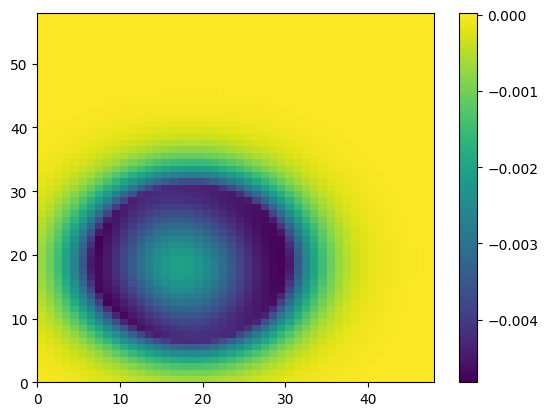

In [12]:
G = amplitude*dsu.gaussian_mixture(densities[0].shape, variance, [(58,48.2)])
plt.pcolormesh((densities[0]-G)[30:,40:])
plt.colorbar()
plt.show()

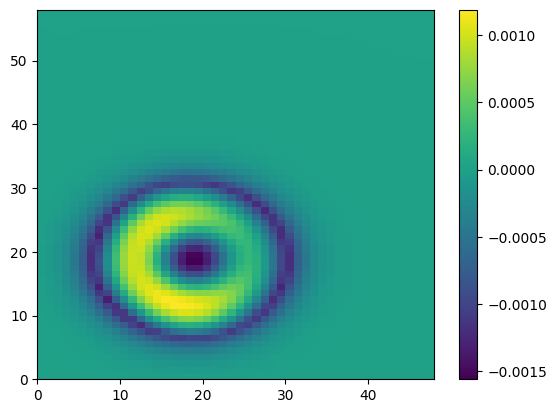

In [13]:
params = qubo_solution.fit_gaussian(densities[0])
var, amp = params[0], params[3]
G = amp*dsu.gaussian_mixture(densities[0].shape, var, [(58,48.2)])
plt.pcolormesh((densities[0]-G)[30:,40:])
plt.colorbar()
plt.show()

In [ ]:
G = amplitude*dsu.gaussian_mixture(densities[0].shape, variance, [(58,48.2)])
plt.pcolormesh((densities[0]-G)[30:,40:])
plt.colorbar()
plt.show()